In [1]:
%pylab inline
import MAS_library as MASL
import programas as pg

Populating the interactive namespace from numpy and matplotlib


# testo la funcion para interpolar de pylians

In [2]:
field = np.zeros([3,3])
field[1,1] = 1

In [3]:
field

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [4]:
path = '/mnt/projects/bias_mock/'
filename_bias = 'rhogal_eul_bias_gaus'
field = np.load(path+filename_bias+'.npy')

In [13]:
BoxSize = 1440.0

# Define la posición donde se quiere interpolar
pos = np.array([[0.1, 0.120, 1439.9]], dtype=np.float32)

# Array para almacenar el resultado de la interpolación
den = np.zeros(pos.shape[0], dtype=np.float32)

# Llama a la función de interpolación
MASL.CIC_interp(field, BoxSize, pos, den)

# El resultado estará en `den`
print("Densidad interpolada:", den[0])

Densidad interpolada: 0.008548877


# ¿ Como lo aplico en mi funcion de perfiles ? 

In [6]:
nbines = 30 
rmin = 0
rmax = 3
bineado = np.linspace(rmin,rmax,nbines+1)
rvoid = 10
lbox = 1440
ngrid = 540

bin_size = lbox/ngrid

    #puntos = 80
perfil = np.zeros(bineado.shape[0] - 1)

x = 300
y= 300
z = 300

i = 0
for radio in bineado[1:2]:
    puntos = 10
    posx, posy, posz = pg.fibo_points(x,y,z,radio*rvoid,puntos,ngrid)
    field_count1 = []
    field_count2 = []
    for j in range(puntos):
            
            px = posx[j]
            py = posy[j]
            pz = posz[j]
            
            # version mia
            field_value = pg.interpolador(px,py,pz,field,bin_size)
            field_count1.append(field_value)
            
            # version pylians
            pos = np.array([[px, py, pz]], dtype=np.float32)
            den = np.zeros(pos.shape[0], dtype=np.float32)
            MASL.CIC_interp(field, BoxSize, pos, den)
            field_count2.append(den[0])
            
    perfil[i] = np.mean(field_count2)
    i = i + 1

In [7]:
field_count2

[0.005294937,
 0.0057266057,
 0.006350452,
 0.0028206552,
 0.0056402036,
 0.0036958973,
 0.0024971527,
 0.0037391293,
 0.0020223442,
 0.0021474997]

## Tiene en cuenta mi funcion fibo la periodicidad ? 

In [19]:
x = 0.1
y = 120
z = 120
r = 10
x,y, z = pg.fibo_points(x,y,z,r,100,540)

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Dibujar puntos
ax.scatter(x, y, z)

# Etiquetas de los ejes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Corrijo por periodicidad

In [21]:
x = 0.1
y = 120
z = 120
r = 10
x,y, z = pg.fibo_points(x,y,z,r,100,540)

In [29]:
def correct_positions_periodicity(coordinates,lbox):
    # corrijo valores negativos
    seleccion, = np.where(coordinates < 0)
    if len(seleccion)>0:
        diference = abs(coordinates[seleccion])
        coordinates[seleccion] = lbox - diference
    del seleccion
    
    # corrijo valores mas grandes que lbox
    seleccion, = np.where(coordinates > lbox)
    if len(seleccion)>0:
        diference = coordinates[seleccion] - lbox
        coordinates[seleccion] = diference
        
    del seleccion
    
    return coordinates

In [34]:
def correct_positions_periodicity(x, period):
    return (x % period)

In [35]:
x = np.array([-1,2,12])
correct_positions_periodicity(x,10)

array([9, 2, 2])

In [8]:
def numero_de_puntos(distance):
    nmin = 10
    if distance < 1:
        p = nmin
    if distance >= 1:    
        p = int(nmin*distance**2)
        
    return p

In [9]:
def perfil_interpolado(x,y,z,bineado,rvoid,field,bin_size,lbox):
    
    ngrid = field.shape[0]
    #puntos = 80
    perfil = np.zeros(bineado.shape[0] - 1)
    
    i = 0
    for radio in bineado[1:]:
        puntos = numero_de_puntos(radio)
        posx, posy, posz = pg.fibo_points(x,y,z,radio*rvoid,puntos,ngrid)
        
        field_count = []
        for j in range(puntos):
            
            px = posx[j]
            py = posy[j]
            pz = posz[j]
            
            #field_value = pg.interpolador(px,py,pz,field,bin_size)
            #field_count.append(field_value)
            
            pos = np.array([[px, py, pz]], dtype=np.float32)
            den = np.zeros(pos.shape[0], dtype=np.float32)
            MASL.CIC_interp(field, lbox, pos, den)
            field_count.append(den[0])
            
        perfil[i] = np.mean(field_count)
        i = i + 1
        
    return perfil

In [10]:
v = np.loadtxt('/mnt/projects/bias_mock/voids/sphvds_raul-RedSample_1e-03-0.9.dat')

In [11]:
field = np.load('/mnt/projects/bias_mock/galaxies/smoothed_fields/galpos_RedSample_1e-03_CIC_Top-Hat_rscale_1.npy')

In [12]:
nbines = 30 
rmin = 0
rmax = 3
bineado = np.linspace(rmin,rmax,nbines+1)

rhomean = np.mean(field)
ngrid = field.shape[0]
lbox = 1440.0
bin_size = lbox/ngrid

In [13]:
x = v[0,2]
y = v[0,3]
z = v[0,4]
rvoid = v[0,1]
print(x,y,z,rvoid)

15.47603416442871 2.688429594039917 0.1226155757904053 13.89713478088379


In [14]:
sel, = np.where((v[:,2]>300) & (v[:,2]<1100) & (v[:,3]>300) & (v[:,3]<1100) & (v[:,4]>300) & (v[:,4]<1100))
len(sel)

5506

In [15]:
x = v[sel,2][0]
y = v[sel,3][0]
z = v[sel,4][0]
rvoid = v[sel,1][0]

In [45]:
x = 1.0
y = 120.0
z = 100.12
rvoid = 13.8

In [46]:
profile = perfil_interpolado(x,y,z,bineado,rvoid,field,bin_size,lbox)

ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'

In [17]:
plt.plot(profile)

In [26]:
import pandas as pd
df = pd.read_csv('perfiles_interp_density_field_mio_pruebas.csv', delimiter=',')

In [37]:
asd = np.array((df['media']))

In [43]:
field_name = 'density_field_mio'
field = np.load(field_name+'.npy')
np.mean(field)

0.00199999196244856

In [42]:
np.min(field)

-1.0000178

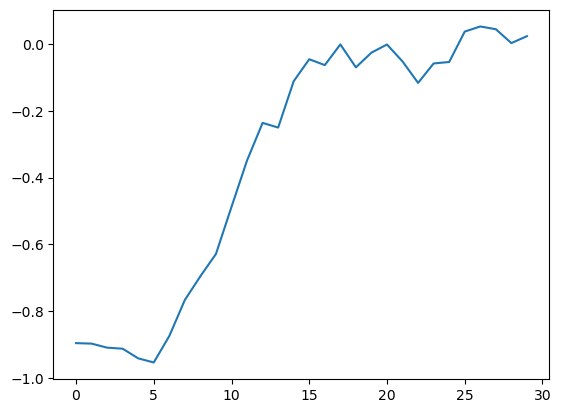

In [44]:
plt.plot(asd/np.mean(field)-1)